In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
from models import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from fastai.column_data import *

In [5]:
from fastai.conv_learner import *
from fastai.dataset import *

In [6]:
import numpy as np

In [7]:
ls -f KITTI/ | grep .csv

validation.csv
validation_192_640.csv
training.csv
validation_192_640_pre.csv
training_192_640_pre.csv
training_192_640.csv


In [8]:
ls KITTI/2011_10_03/2011_10_03_drive_0034_sync/image_03/data/0000003783.png

KITTI/2011_10_03/2011_10_03_drive_0034_sync/image_03/data/0000003783.png


train, val= pd.read_csv('./KITTI/training.csv'), pd.read_csv('./KITTI/validation.csv')

In [9]:
train, val= pd.read_csv('./KITTI/training_192_640_pre.csv'), pd.read_csv('./KITTI/validation_192_640_pre.csv')

In [10]:
for i in range(3):
    train = train.sample(frac=1)
    

train.reset_index(drop=True, inplace=True)

In [11]:
for i in range(3):
    val = val.sample(frac=1)

val.reset_index(drop=True, inplace=True);

In [12]:
train.head()

,t0,t1,t2,fx,fy,cx,cy
0,2011_09_30/2011_09_30_drive_0028_sync/image_03...,2011_09_30/2011_09_30_drive_0028_sync/image_03...,2011_09_30/2011_09_30_drive_0028_sync/image_03...,364.362615,362.030694,310.151266,93.752525
1,2011_09_26/2011_09_26_drive_0096_sync/image_02...,2011_09_26/2011_09_26_drive_0096_sync/image_02...,2011_09_26/2011_09_26_drive_0096_sync/image_02...,371.806866,369.427302,314.104631,88.501248
2,2011_09_30/2011_09_30_drive_0027_sync/image_03...,2011_09_30/2011_09_30_drive_0027_sync/image_03...,2011_09_30/2011_09_30_drive_0027_sync/image_03...,364.362615,362.030694,310.151266,93.752525
3,2011_09_26/2011_09_26_drive_0084_sync/image_03...,2011_09_26/2011_09_26_drive_0084_sync/image_03...,2011_09_26/2011_09_26_drive_0084_sync/image_03...,371.806866,369.427302,314.104631,88.501248
4,2011_09_30/2011_09_30_drive_0033_sync/image_02...,2011_09_30/2011_09_30_drive_0033_sync/image_02...,2011_09_30/2011_09_30_drive_0033_sync/image_02...,364.362615,362.030694,310.151266,93.752525


In [13]:
val.head()

,t0,t1,t2,fx,fy,cx,cy
0,2011_10_03/2011_10_03_drive_0034_sync/image_02...,2011_10_03/2011_10_03_drive_0034_sync/image_02...,2011_10_03/2011_10_03_drive_0034_sync/image_02...,370.424992,368.054272,312.885179,94.830438
1,2011_09_26/2011_09_26_drive_0064_sync/image_02...,2011_09_26/2011_09_26_drive_0064_sync/image_02...,2011_09_26/2011_09_26_drive_0064_sync/image_02...,371.806866,369.427302,314.104631,88.501248
2,2011_09_30/2011_09_30_drive_0034_sync/image_02...,2011_09_30/2011_09_30_drive_0034_sync/image_02...,2011_09_30/2011_09_30_drive_0034_sync/image_02...,364.362615,362.030694,310.151266,93.752525
3,2011_09_26/2011_09_26_drive_0104_sync/image_02...,2011_09_26/2011_09_26_drive_0104_sync/image_02...,2011_09_26/2011_09_26_drive_0104_sync/image_02...,371.806866,369.427302,314.104631,88.501248
4,2011_09_26/2011_09_26_drive_0061_sync/image_02...,2011_09_26/2011_09_26_drive_0061_sync/image_02...,2011_09_26/2011_09_26_drive_0061_sync/image_02...,371.806866,369.427302,314.104631,88.501248


In [14]:
trn0, trn1, trn2, trn_camera = train.t0, train.t1,train.t2, train[['fx', 'fy', 'cx', 'cy']]

In [15]:
val0, val1, val2, val_camera  = val.t0, val.t1, val.t2, val[['fx', 'fy', 'cx', 'cy']]

In [16]:
trn_camera.head()

,fx,fy,cx,cy
0,364.362615,362.030694,310.151266,93.752525
1,371.806866,369.427302,314.104631,88.501248
2,364.362615,362.030694,310.151266,93.752525
3,371.806866,369.427302,314.104631,88.501248
4,364.362615,362.030694,310.151266,93.752525


val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

In [17]:
aug_tfms = [
    #RandomDihedral(tfm_y=TfmType.NO),
    RandomLighting(b=0.05, c=0.05)]

In [18]:
arch = f
scale,bs = 1, 8
#scale,bs = 4, 32
sz = None #np.array([345, 1242]) 
sz_y = None 

PATH = 'Fastai_TRN'

In [19]:
class UnsupFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        super().__init__(fnames, transform, path)
    def get_y(self, i): return None
    def get_c(self): return 0

In [20]:
class UnShuffleImageData(ImageData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,False),(val_ds,False),(fix_ds,False),(aug_ds,False),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]

In [21]:
class UnScaleTransforms():
    def __init__(self, sz, tfms, normalizer, denorm,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        self.tfms = tfms
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)

In [22]:
# just a little modification which remove the multipler at the batch size of the val DL
class UnDBSColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, is_reg=True, is_multi=False, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs), is_reg=is_reg, is_multi=is_multi) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y, is_reg=is_reg, is_multi=is_multi),
                   PassthruDataset(*(val_xs.T), val_y, is_reg=is_reg, is_multi=is_multi),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        trn_ds  = ColumnarDataset.from_data_frame(trn_df,  cat_flds, trn_y, is_reg, is_multi)
        val_ds  = ColumnarDataset.from_data_frame(val_df,  cat_flds, val_y, is_reg, is_multi)
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None,  is_reg, is_multi) if test_df is not None else None
        return cls(path, trn_ds, val_ds, bs, test_ds=test_ds, shuffle=shuffle)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df, shuffle=shuffle)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


class Transforms():
    def __init__(self, sz, tfms, normalizer, denorm, crop_type=CropType.CENTER,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)
    

def image_gen(normalizer, denorm, sz, tfms=None, max_zoom=None, pad=0, crop_type=None,
              tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, scale=None):
    """
    Generate a standard set of transformations

    Arguments
    ---------
     normalizer :
         image normalizing function
     denorm :
         image denormalizing function
     sz :
         size, sz_y = sz if not specified.
     tfms :
         iterable collection of transformation functions
     max_zoom : float,
         maximum zoom
     pad : int,
         padding on top, left, right and bottom
     crop_type :
         crop type
     tfm_y :
         y axis specific transformations
     sz_y :
         y size, height
     pad_mode :
         cv2 padding style: repeat, reflect, etc.

    Returns
    -------
     type : ``Transforms``
         transformer for specified image operations.

    See Also
    --------
     Transforms: the transformer object returned by this function
    """
    if tfm_y is None: tfm_y=TfmType.NO
    if tfms is None: tfms=[]
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    if sz_y is None: sz_y = sz
    if scale is None:
        scale = [RandomScale(sz, max_zoom, tfm_y=tfm_y, sz_y=sz_y) if max_zoom is not None
                 else Scale(sz, tfm_y, sz_y=sz_y)]
    elif not is_listy(scale): scale = [scale]
    if pad: scale.append(AddPadding(pad, mode=pad_mode))
    if crop_type!=CropType.GOOGLENET: tfms=scale+tfms
    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y)

def noop(x):
    """dummy function for do-nothing.
    equivalent to: lambda x: x"""
    return x

transforms_basic    = [RandomRotate(10), RandomLighting(0.05, 0.05)]
transforms_side_on  = transforms_basic + [RandomFlip()]
transforms_top_down = transforms_basic + [RandomDihedral()]

imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
"""Statistics pertaining to image data from image net. mean and std of the images of each color channel"""
inception_stats = A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (inception_4, inceptionresnet_2)

def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    if aug_tfms is None: aug_tfms=[]
    tfm_norm = Normalize(*stats, tfm_y=tfm_y if norm_y else TfmType.NO) if stats is not None else None
    tfm_denorm = Denormalize(*stats) if stats is not None else None
    val_crop = CropType.CENTER if crop_type in (CropType.RANDOM,CropType.GOOGLENET) else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop,
            tfm_y=tfm_y, sz_y=sz_y, scale=scale)
    trn_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=crop_type,
            tfm_y=tfm_y, sz_y=sz_y, tfms=aug_tfms, max_zoom=max_zoom, pad_mode=pad_mode, scale=scale)
    return trn_tfm, val_tfm


def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)

    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms, max_zoom=max_zoom, pad=pad, crop_type=crop_type,
                           tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode, norm_y=norm_y, scale=scale)


    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y, )

In [23]:
stats = imagenet_stats # from fastai library
tfm_norm = Normalize(*stats, tfm_y=TfmType.NO) 
tfm_denorm = Denormalize(*stats)

In [24]:
trn_tfms = UnScaleTransforms(sz=None, tfms=[], normalizer=tfm_norm, denorm=tfm_denorm, tfm_y=TfmType.NO, sz_y=sz_y)
val_tfms = UnScaleTransforms(sz=None, tfms=[], normalizer=tfm_norm, denorm=tfm_denorm, tfm_y=TfmType.NO, sz_y=sz_y)

In [25]:
imgnet_mean, imgnet_std = torch.from_numpy(stats[0]).float(), torch.from_numpy(stats[1]).float()
imgnet_mean, imgnet_std = imgnet_mean.view(1,3,1,1), imgnet_std.view(1,3,1,1)

In [26]:
def denorm(imgs, mean, std):
    return V(imgs.cpu().data * std + mean)

In [27]:
def get_MD(trn, val):
    
#     tfms = tfms_from_model(
#         arch,
#         sz,
#         crop_type=CropType.NO,
#         tfm_y=TfmType.NO,
#         aug_tfms=aug_tfms,
#         sz_y=sz_y)

    tfms = (trn_tfms, val_tfms)
    
    datasets = ImageData.get_ds(
        UnsupFilesDataset,
        (trn, None),
        (val, None),
        tfms, path='KITTI/')
    md = UnShuffleImageData(
        PATH,
        datasets,
        bs, num_workers=16,
        classes=None)
    
    return md

In [28]:
def get_cam(trn_cam, val_cam):
    return UnDBSColumnarModelData.from_data_frames(
        path= None,
        trn_df=trn_cam, val_df=val_cam,
        trn_y=None, val_y=None,
        cat_flds=[],
        bs=bs, shuffle=False)

In [29]:
MD1 = get_MD(trn0, val0)
MD2 = get_MD(trn1, val1)
MD3 = get_MD(trn2, val2)
MDcam = get_cam(trn_camera, val_camera)

In [30]:
# f, cut comes from models
m = TriDepth(get_base(f, cut), 1).cuda()

In [31]:
set_trainable(m.depth.rn, True)

In [32]:
l = Loss(scale=1, Tscale=1).cuda() 

In [33]:
#opt = optim.SGD(filter(lambda p: p.requires_grad, m.parameters()), lr=0.001, momentum=0.9)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr =1e-4,)

imgbatch1 = next(iter(MD1.trn_dl))
imgbatch2 = next(iter(MD2.trn_dl))
imgbatch3 = next(iter(MD3.trn_dl))
cambatch = next(iter(MDcam.trn_dl))

img1 = MD1.trn_ds.denorm(imgbatch1)[0]
img2 = MD2.trn_ds.denorm(imgbatch2)[0]
img3 = MD3.trn_ds.denorm(imgbatch3)[0]
cam = cambatch[1][0]

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

print(cam.cpu().numpy().reshape(-1))

DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

d1, d2, d3, poses_x2 = m(imgs1, imgs2, imgs3)

loss, details = l(d1, d2, d3, poses_x2, imgs1, imgs2, imgs3, cam)
loss.backward()
opt.step()
losses.append(loss)

l1_loss(imgs1, imgs2, mask=V(torch.ones_like(imgs1)))

In [34]:
DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
losses = []
verbose = 20

In [35]:
for i in range(len(MD1.trn_ds)//bs-len(losses)):
    opt.zero_grad()
    imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])
    
    d1, d2, d3, trans, rotation, = m(imgs1, imgs2, imgs3)
    
    imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 
    
    loss, details = l(d1, d2, d3, trans, rotation, imgs1, imgs2, imgs3, cam)
    loss.backward()
    opt.step()
    losses.append(loss.data[0])
    # appr smooth ssim l1
    if i%verbose == 0: print(loss.data[0],
                             details[0].data[0],
                             details[1].data[0],
                             details[2].data[0],
                             details[3].data[0],
                             sep='\t')

0.15509995818138123	0.13195441663265228	0.023145539686083794	0.0	0.13195441663265228
0.11621381342411041	0.10220851749181747	0.014005295000970364	0.0	0.10220851749181747
0.10236138105392456	0.09360053390264511	0.008760844357311726	0.0	0.09360053390264511
0.10275787860155106	0.0970999002456665	0.005657980218529701	0.0	0.0970999002456665
0.103975310921669	0.09984519332647324	0.004130120854824781	0.0	0.09984519332647324
0.09973783046007156	0.09624750167131424	0.0034903318155556917	0.0	0.09624750167131424
0.1146850660443306	0.11197497695684433	0.002710089087486267	0.0	0.11197497695684433
0.09078965336084366	0.08860006183385849	0.0021895950194448233	0.0	0.08860006183385849
0.08788885176181793	0.08604800701141357	0.0018408438190817833	0.0	0.08604800701141357
0.08647102862596512	0.08471717685461044	0.0017538535175845027	0.0	0.08471717685461044
0.07963135838508606	0.07822033017873764	0.0014110285555943847	0.0	0.07822033017873764
0.06483699381351471	0.06360552459955215	0.001231466419994831	0.0	

0.06712958961725235	0.06628930568695068	0.0008402806706726551	0.0	0.06628930568695068
0.08971763402223587	0.08886297792196274	0.0008546562748961151	0.0	0.08886297792196274
0.05838007107377052	0.05755450204014778	0.0008255693246610463	0.0	0.05755450204014778
0.07021012902259827	0.06939730793237686	0.0008128245244733989	0.0	0.06939730793237686
0.07317578792572021	0.07234758883714676	0.0008281984482891858	0.0	0.07234758883714676
0.08791905641555786	0.08711674064397812	0.0008023144328035414	0.0	0.08711674064397812
0.0993257462978363	0.09845630079507828	0.0008694485877640545	0.0	0.09845630079507828
0.08150841295719147	0.08067715913057327	0.0008312537684105337	0.0	0.08067715913057327
0.06393373757600784	0.06314610689878464	0.0007876321324147284	0.0	0.06314610689878464
0.07484625279903412	0.0740448385477066	0.0008014144259504974	0.0	0.0740448385477066
0.09343760460615158	0.09260594099760056	0.0008316668681800365	0.0	0.09260594099760056
0.07921425253152847	0.07838156819343567	0.000832683406770

0.060702141374349594	0.05996813252568245	0.0007340071606449783	0.0	0.05996813252568245
0.0635124146938324	0.0627891942858696	0.000723223842214793	0.0	0.0627891942858696
0.050699375569820404	0.0500338189303875	0.0006655563483946025	0.0	0.0500338189303875
0.08835940808057785	0.08760405331850052	0.0007553561008535326	0.0	0.08760405331850052
0.04897722229361534	0.0482543520629406	0.0007228705217130482	0.0	0.0482543520629406
0.06696673482656479	0.06624728441238403	0.0007194517529569566	0.0	0.06624728441238403
0.060481052845716476	0.05981336906552315	0.0006676833145320415	0.0	0.05981336906552315
0.05850397050380707	0.05786969140172005	0.0006342791020870209	0.0	0.05786969140172005
0.055487919598817825	0.05478096008300781	0.0007069585844874382	0.0	0.05478096008300781
0.05972756817936897	0.05905282497406006	0.0006747415754944086	0.0	0.05905282497406006
0.06943356245756149	0.06877211481332779	0.0006614443846046925	0.0	0.06877211481332779
0.06495098769664764	0.06429475545883179	0.0006562327034771

In [ ]:
verbose = 500

In [36]:
def plot_losses(losses):
    plt.plot(np.arange(len(losses)), np.array(losses))

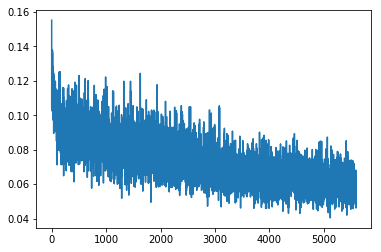

In [37]:
plot_losses(losses)

In [38]:
def train(m, opt, MD1, MD2, MD3, MDcam):
    DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
    losses = []  

    for i in range(len(MD1.trn_ds)//bs-len(losses)):
        opt.zero_grad()
        imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

        d1, d2, d3, trans, rotation, = m(imgs1, imgs2, imgs3)

        imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 

        loss, details = l(d1, d2, d3, trans, rotation, imgs1, imgs2, imgs3, cam)
        loss.backward()
        opt.step()
        losses.append(loss.data[0])
        # appr smooth ssim l1
        if i%verbose == 0: print(loss.data[0],
                                 details[0].data[0],
                                 details[1].data[0],
                                 details[2].data[0],
                                 details[3].data[0],
                                 sep='\t')
    return losses

In [39]:
def fit(epoch, m, opt, MD1, MD2, MD3, MDcam):
    for i in range(epoch):
        print("--------------------epoch {} start:----------------------".format(i))
        losses = train(m, opt, MD1, MD2, MD3, MDcam)
        losses= [ str(loss) for loss in losses ]
        folder = Path("./tmp")
        folder.mkdir(exist_ok=True)
        file = folder / 'epoch{}.log'.format(i)
        with file.open('w') as f:
            f.write("\n".join(losses))
        save_model(m, str(folder / "epoch{}.M".format(i)))

In [41]:
fit(5, m, opt, MD1, MD2, MD3, MDcam)

--------------------epoch 0 start:----------------------
0.06161371245980263	0.060934554785490036	0.0006791568011976779	0.0	0.060934554785490036


KeyboardInterrupt: 

In [40]:
from fastai.torch_imports import save_model, load_model

In [41]:
MODEL_PATH = "./TriDepth.M"

In [42]:
save_model(m, MODEL_PATH)

In [ ]:
load_model(m, MODEL_PATH)

In [43]:
ls -l *.M

-rw-rw-r-- 1 paperspace paperspace 91055450 Sep  7 14:55 TriDepthBoth.M
-rw-rw-r-- 1 paperspace paperspace 55856201 Oct 26 22:19 TriDepth.M


verbose = 20
def fit(model, metric, opt, MD1, MD2, MD3, MDcam):
    DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
    losses = []
    for i in range(len(MD1.trn_ds)//bs):
        opt.zero_grad()
        imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])
        
        d1, d2, d3, poses_x2 = m(imgs1, imgs2, imgs3)
        loss, details = l(d1, d2, d3, poses_x2, imgs1, imgs2, imgs3, cam)
        loss.backward()
        opt.step()
        losses.append(loss.data[0])
        if i%verbose == 0: print(loss.data[0],
                                 details[0].data[0],
                                 details[1].data[0],
                                 details[2].data[0],
                                 details[3].data[0],
                                 sep='\t')
    return A(loesses).mean()

fit(m, l, opt, MD1, MD2, MD3, MDcam)

In [44]:
DL1, DL2, DL3, DLcam = iter(MD1.val_dl), iter(MD2.val_dl), iter(MD3.val_dl), iter(MDcam.val_dl)

In [45]:
imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

In [46]:
d1s, d2s, d3s, transistion, rotation = m(imgs1, imgs2, imgs3)

In [47]:
i = 0
d2 = d2s[i]
#d1, d2, d3 = d1s[0], d2s[0], d3s[0]

In [48]:
if i>0: d2 = F.upsample(input=d2, scale_factor=2**i, mode='bilinear')
cx12, cy12, dm12 = l.appr.offset.forward(trans=transistion[:,0], rotation=rotation[:,0], inv_depth = d2, camera = cam)
#cx32, cy32, dm32 = l.appr.offset.forward(trans=transistion[:,1], rotation=rotation[:,1], inv_depth = d2, camera = cam)

x12, ivm12 = l.appr.sampler.forward(imgs1, cx12, cy12)
#x32, ivm32 = l.appr.sampler.forward(imgs2, cx32, cy32) 

In [49]:
cx12.shape

torch.Size([8, 192, 640])

In [50]:
transistion.shape, rotation.shape

(torch.Size([8, 2, 3]), torch.Size([8, 2, 3]))

In [51]:
transistion[2,0]

Variable containing:
1.00000e-02 *
 -0.0048
 -0.0281
  3.5243
[torch.cuda.FloatTensor of size 3 (GPU 0)]

In [52]:
rotation[2,0]

Variable containing:
1.00000e-04 *
  5.6499
 -3.2567
 -8.5350
[torch.cuda.FloatTensor of size 3 (GPU 0)]

In [54]:
def plot_depth(depth, index=0, figsize=(12,4), scale=50, inv=True, cb=True, cmap='plasma'):
    inv_depth = depth.cpu().data[index].numpy()
    inv_depth = np.clip(inv_depth, a_min=0.01, a_max=None)
    if inv:
        depth = 1/inv_depth[0]
    else:
        depth = inv_depth[0]
        
    m, std, mx = depth.mean(axis=(0, 1)), depth.std(axis=(0, 1)), depth.max(axis=(0, 1))
    plt.figure(figsize=figsize)
    plt.imshow(
        depth*scale,
        cmap=cmap,
        #vmin=max(m - 2*std, 0),
        #vmax=min(m+2*std, mx)
    )
    if cb: plt.colorbar()
    plt.axis('off')

In [55]:
def plot_img(recon, index=0, figsize=(12,4)):
    recon = MD1.trn_ds.denorm(recon)[index]
    plt.figure(figsize=figsize)
    plt.imshow(recon)
    plt.axis('off')    

In [56]:
def plot_mask(mask, index=0, figsize=(12,4)):
    plt.style.use('grayscale')
    mask = mask[index]
    plt.figure(figsize=figsize)
    plt.imshow(mask.cpu().data.numpy(),cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.axis('off')

In [87]:
index = 5

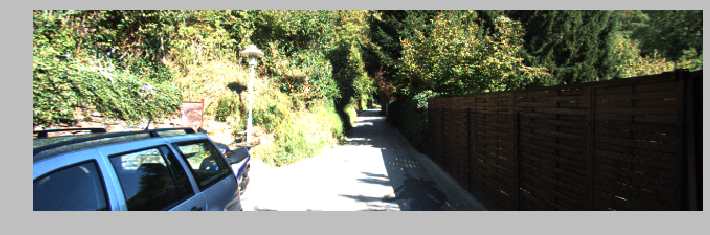

In [88]:
plot_img(imgs1, index)

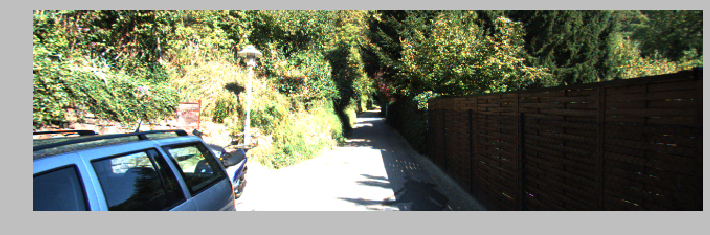

In [89]:
plot_img(imgs2, index)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


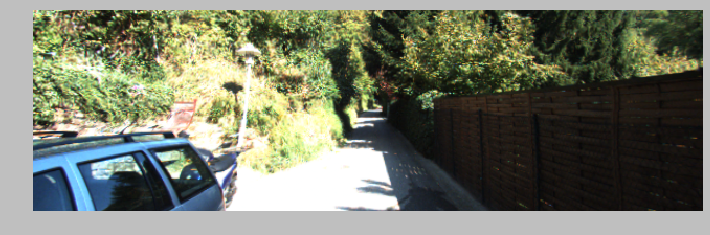

In [90]:
plot_img(x12, index)

plot_img(x32, index)

In [91]:
npd2 = 1/(d2.cpu() + 0.01).data.numpy()

In [92]:
npd2.mean(), npd2.std(), npd2.min(), npd2.max()

(0.670564, 0.52885526, 0.20064148, 3.965174)

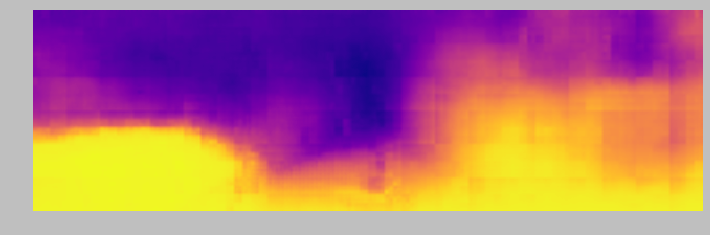

In [93]:
plot_depth(d2, index, scale=1, inv=False, cb=False, cmap='plasma')

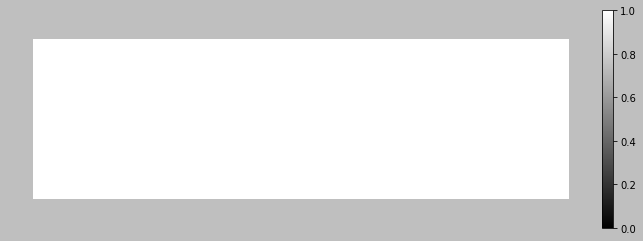

In [64]:
plot_mask(ivm12, index)

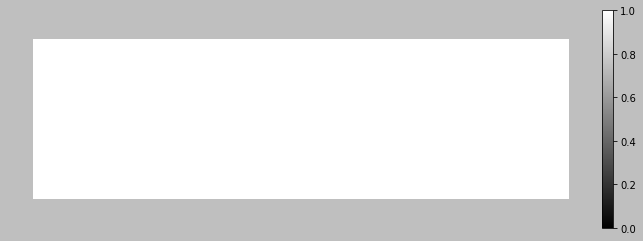

In [65]:
plot_mask(dm12, index)

plot_mask(ivm32, index)

plot_mask(dm32, index)

In [ ]:
imgs1[0].mean(), imgs1[0].std()

In [ ]:
d2[0].mean(), d2[0].std()

In [ ]:
ssim_loss(imgs1, imgs2, V(torch.ones_like(imgs1)))

In [ ]:
l1_loss(imgs1, imgs2, V(torch.ones_like(imgs1)))